In [ ]:
# Install fastai
!pip install fastai -q
!pip install fastai --upgrade

In [101]:
from fastai.tabular.all import *
import pandas as pd
import csv

Add the 'level1.csv' and 'test_level1.csv' files into the current directory. You can do this by clicking the folder icon on the left hand side and drag the csvs into the empty space.

In [330]:
# Load the csv as a dataframe
path = Path(".")
df1 = pd.read_csv(path/'level3.csv')
# Remove the id column from R's dataframe
del df1['Unnamed: 0']

In [103]:
# Check the first categorical variable before duration
###list(df1.columns)[6]

In [ ]:
# Check duration
###list(df1.columns)[7]

In [331]:
# Get a list of categorical columns
df1_cat = list(df1.columns)

###df1_cat = df1_cat[0:6] + df1_cat[9: ]

# For level3
df1_cat = df1_cat[0:6] + df1_cat[8: ]
# Only age and duration are numerical, the others are categorical

In [ ]:
df1_cat

In [333]:
# Convert confirmed date into datetime
df1['confirmed'] = pd.to_datetime(df1['confirmed'])
df1['confirmed'] = (df1['confirmed'] - pd.to_datetime('1970-01-01')).dt.total_seconds()

In [334]:
# Get a list of numerical columns, not counting the thing we're predicting
df1_num = list(df1.columns)
###df1_num = df1_num[6:7] + df1_num[8:9]
# Level 3 code
df1_num = df1_num[6:7]
# The only numerical columns are the age and duration
# We don't include duration because we are predicting it

# This column should be about age
###list(df1.columns)[8]
# Level 3 code
list(df1.columns)[6] # Should be confirmed

'confirmed'

In [ ]:
# Uncomment below to check types of the columns
###df1.dtypes

In [ ]:
# I determined the y_range by using
# ```max(merged_df1$duration)```
# in R and adding one to the maximum. I remember it being recommended
# by the fast.ai prof, I think because the neuron is asymptotic to
# the maximum value, I'm not entirely sure.

In [337]:
# Training and validation splits
splits = RandomSplitter(valid_pct=0.2)(range_of(df1))

In [338]:
# This is some a data cleaning step
to = TabularPandas(df1, procs = [Categorify, FillMissing, Normalize],
                   cat_names = df1_cat, cont_names = df1_num,
                   y_names = 'duration',
                   splits = splits)
# This determines batch size
dls = to.dataloaders(bs = 4)
# If you get an error about nan values, try re-running the splits code chunk
# above and then run this code chunk again

In [339]:
# y_range is used so that the model knows it's doing regression
# I chose 33 because the max of the training duration is 32
# We are using 2 hidden layers, 50 neurons in the first, 25 in the second
learn = tabular_learner(dls, y_range = (0, 33), metrics = rmse,
                        layers = [30, 15])
# Good layers is layers = [50, 25]

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.3182567499825382e-06)

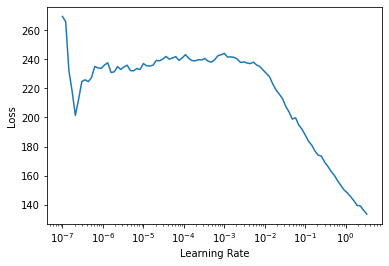

In [340]:
# Use this to figure out what learning rate to use
learn.recorder.lr_find()

In [341]:
learn.fit_one_cycle(10, lr_max = 0.0398, wd=0.8)
# Without moms=(0.8, 0.2, 0.8): 5.0498

epoch,train_loss,valid_loss,_rmse,time
0,120.995781,29.981272,5.475516,00:00
1,55.027359,13.128194,3.623285,00:00
2,39.453331,14.824367,3.850242,00:00
3,36.112686,23.225632,4.819298,00:00
4,31.753130,23.696093,4.867863,00:00
5,27.032227,15.310551,3.912870,00:00
6,23.353010,20.725100,4.552483,00:00
7,21.588772,13.344761,3.653048,00:00
8,21.333654,10.294392,3.208487,00:00
9,18.748692,10.973211,3.312584,00:00


In [342]:
# Load the test set
df2 = pd.read_csv(path/'test_level3.csv')

In [343]:
# Look at the first column
list(df2.columns)[0]

'Unnamed: 0'

In [344]:
# Remove the id column from R's dataframe
del df2['Unnamed: 0']

In [345]:
# Convert confirmed date into datetime
df2['confirmed'] = pd.to_datetime(df2['confirmed'])
df2['confirmed'] = (df2['confirmed'] - pd.to_datetime('1970-01-01')).dt.total_seconds()

In [346]:
# Create the test set data frame
dl = learn.dls.test_dl(df2)

In [347]:
# Get the predictions from the model on the test set
p1 = learn.get_preds(dl = dl)

In [348]:
# Get the list of predictions
p2 = p1[0].tolist()

In [349]:
# Print the predictions to a csv file
with open('testing.csv', mode='w') as employee_file:
  employee_writer = csv.writer(employee_file, delimiter = ',',
                               quotechar = '"', quoting = csv.QUOTE_MINIMAL)
  employee_writer.writerow(p2)
print("Done")

Done
